<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Cairo_ALGO_vs_S%26P_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance scipy


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D


In [5]:
data = yf.download("SPY", start="2020-01-01", end="2024-01-01")
prices = data["Close"]

# Log returns
returns = np.log(prices / prices.shift(1)).dropna()

/tmp/ipython-input-1933066360.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [6]:
vol = returns.rolling(20).std()
signal = returns.rolling(10).mean()

# Risk-normalized weights
weights = signal / vol
weights = weights.clip(-2, 2)

strategy_returns = weights.shift(1) * returns
strategy_returns.dropna(inplace=True)


In [8]:
window = 60
bins = np.linspace(-0.05, 0.05, 80)

X, Y, Z = [], [], []

for i in range(window, len(strategy_returns)):
    window_data = strategy_returns[i-window:i]
    kde = gaussian_kde(window_data.values.T)
    density = kde(bins)

    X.append(np.full_like(bins, i))
    Y.append(bins)
    Z.append(density)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

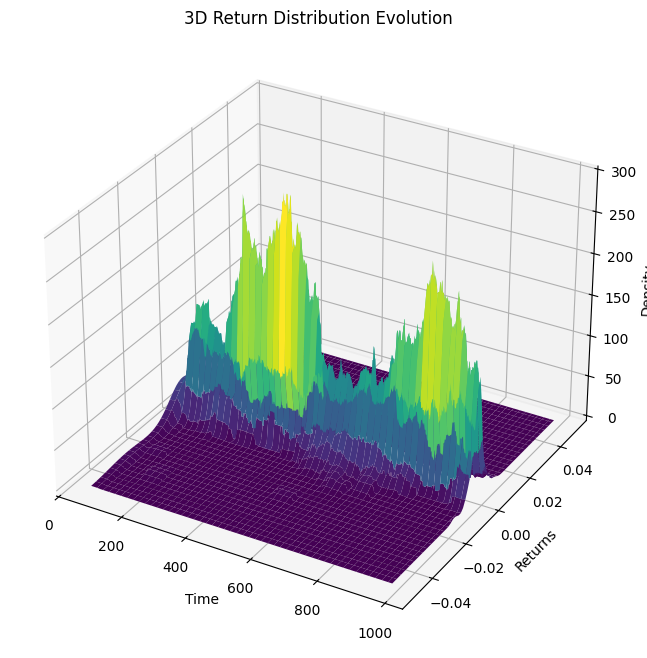

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    X,
    Y,
    Z,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_zlabel("Density")
ax.set_title("3D Return Distribution Evolution")

plt.show()


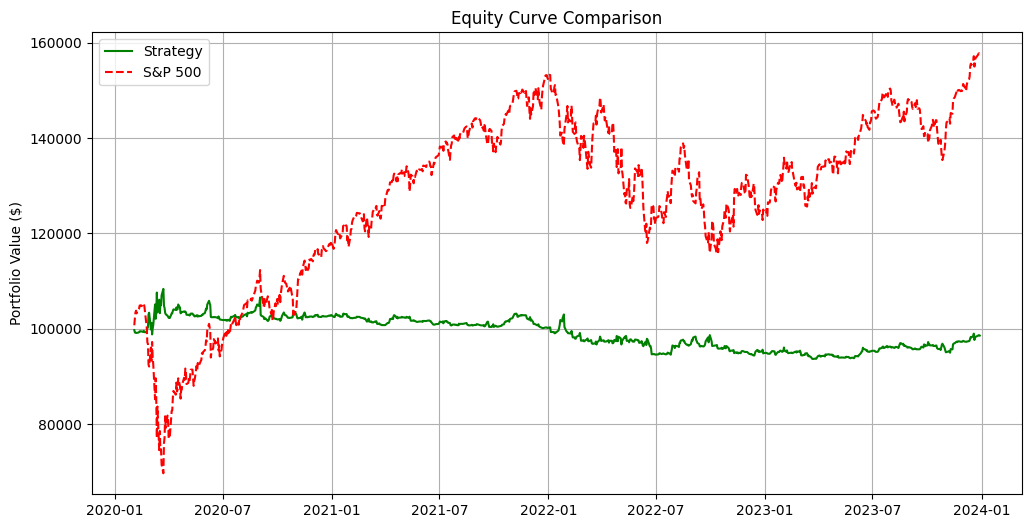

In [10]:
capital = 100_000

strategy_equity = capital * np.exp(strategy_returns.cumsum())
buy_hold_equity = capital * np.exp(returns.loc[strategy_returns.index].cumsum())

plt.figure(figsize=(12,6))
plt.plot(strategy_equity, label="Strategy", color="green")
plt.plot(buy_hold_equity, label="S&P 500", linestyle="--", color="red")

plt.title("Equity Curve Comparison")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
def stats(r):
    return {
        "CAGR": np.exp(r.mean()*252)-1,
        "Volatility": r.std()*np.sqrt(252),
        "Sharpe": r.mean()/r.std()*np.sqrt(252),
        "Skewness": r.skew(),
        "Kurtosis": r.kurtosis()
    }

stats(strategy_returns)


{'CAGR': Ticker
 SPY   -0.003636
 dtype: float64,
 'Volatility': Ticker
 SPY    0.078144
 dtype: float64,
 'Sharpe': Ticker
 SPY   -0.04661
 dtype: float64,
 'Skewness': Ticker
 SPY   -0.739928
 dtype: float64,
 'Kurtosis': Ticker
 SPY    25.076373
 dtype: float64}

# ADDING IMPROVED VERSION

In [12]:
!pip install yfinance scipy matplotlib


In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
